Paper: [Growing Neural Gas Network Learns 
Topologies](https://papers.nips.cc/paper/1994/file/d56b9fc4b0f1be8871f5e1c40c0067e7-Paper.pdf)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.animation as animation
from time import perf_counter

from skimage import img_as_float, color, io, exposure, transform
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

from natsort import natsorted

np.random.seed(8770)

In [2]:
img_name = "Joe_Biden_Signature"

In [3]:
data_path = os.path.join("GNG_data", f"{img_name}.png")
img = plt.imread(data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'GNG_data\\Joe_Biden_Signature.png'

In [ ]:
# binary_img = img[:, :, 0]
binary_img = img[:, :]
np.unique(binary_img)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(binary_img, cmap="gray")
plt.show()

In [ ]:
binary_img.shape

## Image

In [97]:
# img_name,ext = "the_columns", ".jpg"
img_name, ext = "DerekAnderson", ".jpg"
# img_name, ext = "Derek-Anderson-3", ".jpg"
# img_name, ext = "Joe_Biden_Signature", ".jpg"
# img_name, ext = "data-3", ".png"

In [98]:
def preprocess_image(img_name, ext, save=False):
    data_path = os.path.join("GNG_data", f"{img_name}{ext}")
    img = io.imread(data_path)
    img = img_as_float(img)
    if img_name == "the_columns":
        img[600:, :] = 0
        img = transform.resize(img, (342, 512), anti_aliasing=True)
    elif img_name == "DerekAnderson":
        img = img[0:280, 60:250]
    elif img_name == "Derek-Anderson-3":
        img[-120:, 0:100] = 1
    if save:
        io.imsave(f"{img_name}-original.png", img)
    img = color.rgb2gray(img)
    if save:
        io.imsave(f"{img_name}-gray.png", img)
    # img = exposure.equalize_adapthist(img, clip_limit=0.03)
    img = gaussian(img, sigma=0.6)
    if save:
        io.imsave(f"{img_name}-blur.png", img)
    
    otsu_th = 0
    inverse = False
    
    if img_name == "DerekAnderson":
        otsu_th = -0.1
        inverse = True
    elif img_name == "the_columns":
        otsu_th = 0.1
    elif img_name == "Derek-Anderson-3":
        otsu_th = 0#-0.1
        inverse = True
    elif img_name == "Joe_Biden_Signature":
        inverse = True
    
    thresh = threshold_otsu(img) + otsu_th
    img = img > thresh
    if inverse:
        img = np.invert(img)
    if save:
        io.imsave(f"{img_name}-binary.png", img)
    return img

In [99]:
binary_img = preprocess_image(img_name, ext, save=True)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-98-234112cd78c0>:41: UserWarning: DerekAnderson-binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f"{img_name}-binary.png", img)


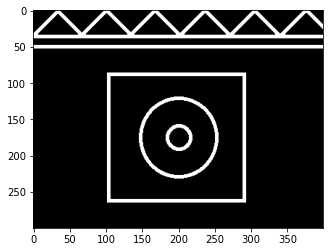

In [7]:
fig, ax = plt.subplots()
ax.imshow(binary_img, cmap="gray")
plt.show()

Nodes
- A set $A$ of nodes.
- Each node $c \in A$ has an associated *reference vector* $\vec{w}_c \in \mathbb{R}^{n}$ which is the position of the node in the input space.

Connections
- A set $N$ of edges.
- Connections are not weighted.
- Define the topological structure of a GNG network.

In [8]:
histories = {}

In [9]:
def get_distance(a, b):
    return np.sum(np.power(a - b, 2))

In [10]:
class GrowingNeuralGas():
    def __init__(self, step=0.1, step_neighbor=0.01, max_age=100, time_add_node=1000, alpha=0.5, d=0.95, max_node=100):
        self.nodes = {}
        self.step = step
        self.step_neighbor = step_neighbor
        self.max_age = max_age
        self.time_add_node = time_add_node
        self.iteration = 1
        self.alpha = alpha
        self.d = d
        self.max_node = max_node
        self.beta = [np.nan, np.nan]
        self.history = []
        self.removed_edges = []
        self.added_edges = []
        self.next_node_id = 0
    
    def get_experiment_name(self):
        return f"step_{self.step}-sn_{self.step_neighbor}-age_{self.max_age}-t_add_{self.time_add_node}-it_{self.iteration}-a_{self.alpha}-d_{self.d}-node_{self.get_num_nodes()}-max_{self.max_node}"
    
    def get_num_nodes(self):
        return len(self.nodes)
        
    def add_node(self, vector):
        node_idx = self.next_node_id
        self.nodes[self.next_node_id] = {
            "vector": vector.astype("float64"),
            "error": 0,
            "neighbors": {}
        }
        self.next_node_id += 1
        return node_idx
    
    def remove_node(self, node_idx):
        del self.nodes[node_idx]
        for i in self.nodes:
            for edge in list(self.nodes[i]["neighbors"]):
                if edge == node_idx:
                    del self.nodes[i]["neighbors"][edge]
    
    def add_edge(self, n1, n2):
        self.nodes[n1]["neighbors"][n2] = 0
        self.nodes[n2]["neighbors"][n1] = 0
    
    def remove_edge(self, node, edge):
        del self.nodes[node]["neighbors"][edge]
        del self.nodes[edge]["neighbors"][node]
#         if edge in self.nodes[node]["neighbors"]:
#             del self.nodes[node]["neighbors"][edge]
#         if node in self.nodes[edge]["neighbors"]:
#             del self.nodes[edge]["neighbors"][node]
            
    def set_age(self, n1, n2, age):
        self.nodes[n1]["neighbors"][n2] = age
        self.nodes[n2]["neighbors"][n1] = age
    
    def add_age(self, n1, n2, age=1):
        self.nodes[n1]["neighbors"][n2] += age
        self.nodes[n2]["neighbors"][n1] += age
    
    def get_vector(self, node):
        return self.nodes[node]["vector"]
    
    def get_error(self, node):
        return self.nodes[node]["error"]
    
    def set_error(self, node, error):
        self.nodes[node]["error"] = error
        
    def increase_error(self, node, error):
        self.nodes[node]["error"] += error
    
    def decrease_error(self, node, error):
        self.increase_error(node, -error)
    
    def multiply_error(self, node, num):
        self.nodes[node]["error"] *= num
    
    def find_closest_nodes(self, beta):
        distances = np.zeros_like(list(self.nodes))
        node_indices = list(self.nodes)
        for i in range(len(distances)):
            distances[i] = get_distance(beta, self.nodes[node_indices[i]]["vector"])
#         distances = np.empty(self.next_node_id)
#         distances[:] = np.nan
#         for i in self.nodes:
#             distances[i] = get_distance(beta, self.nodes[i]["vector"])
        first_closest, second_closest = np.argpartition(distances, kth=1)[:2] # get 2 minimum indices
        return node_indices[first_closest], node_indices[second_closest]
#         return first_closest, second_closest
    
    def initialize(self, nodes):
        for node in nodes:
            self.add_node(node)
        self.add_edge(0, 1)
    
    def visualize(self, fig, ax, signal, show_node=True, show_image=False):
        plt.cla()
        fig.suptitle(f"GNG epoch {self.epoch} (iteration {self.iteration}) {self.history[-1]['time']:.2f} s | #nodes={len(self.nodes)}")
        if show_image:
            img = self.binary_img
        else:
            img = np.zeros_like(self.binary_img)
        ax.imshow(img, cmap="gray", alpha=0.1)
        if signal is not None:
            ax.scatter(signal[1], signal[0], marker="*", color="lime")
        for i in self.nodes:
            node = self.nodes[i]
            x_node = node["vector"][0]
            y_node = node["vector"][1]
            if show_node:
                ax.scatter(y_node, x_node, color="deepskyblue")
            for edge in node["neighbors"]:
                x_neighbor, y_neighbor = self.nodes[edge]["vector"]
                x = [x_node, x_neighbor]
                y = [y_node, y_neighbor]
                ax.plot(y, x, color="lightskyblue")
        ax.set_aspect(1)
        display.clear_output(wait=True)
        display.display(fig)
    
    def draw_image(self, figsize=(12, 8), show_node=True, show_image=True, hide_axes=True, show_suptitle=False):
        fig, ax = plt.subplots(figsize=figsize)
        if show_suptitle:
            fig.suptitle(f"GNG iteration {self.epoch}/{self.max_epoch} #nodes={len(self.nodes)}")
        if show_image:
            img = self.binary_img
        else:
            img = np.zeros_like(self.binary_img)
        ax.imshow(img, cmap="gray", alpha=0.3)
        for i in self.nodes:
            node = self.nodes[i]
            x_node = node["vector"][0]
            y_node = node["vector"][1]
            if show_node:
                ax.scatter(y_node, x_node, color="black", marker=".")
            for edge in node["neighbors"]:
                x_neighbor, y_neighbor = self.nodes[edge]["vector"]
                x = [x_node, x_neighbor]
                y = [y_node, y_neighbor]
                ax.plot(y, x, color="black")
        ax.set_aspect(1)
        
        if hide_axes:
            fig.subplots_adjust(bottom = 0)
            fig.subplots_adjust(top = 1)
            fig.subplots_adjust(right = 1)
            fig.subplots_adjust(left = 0)
            plt.axis('off')
        
        return fig
    
    def animate(self, frame):
        self.ax.clear()
        self.fig.suptitle(f"GNG epoch {self.epoch} (iteration {self.iteration}) | #nodes={len(self.nodes)}")
        self.ax.imshow(binary_img, cmap="gray")
        signal_plot = self.ax.scatter(self.beta[1], self.beta[0], marker="*", color="lime")
        for i in self.nodes:
            node = self.nodes[i]
            x_node = node["vector"][0]
            y_node = node["vector"][1]
            self.ax.scatter(y_node, x_node, color="deepskyblue")
            for edge in node["neighbors"]:
                x_neighbor, y_neighbor = self.nodes[edge]["vector"]
                x = [x_node, x_neighbor]
                y = [y_node, y_neighbor]
                self.ax.plot(y, x, color="lightskyblue")
        return [signal_plot]
    
    def calculate_total_loss(self):
        total_loss = 0
        for i in self.nodes:
            total_loss += self.nodes[i]["error"]
        return total_loss
    
    def record_history(self, time, epoch_error=np.nan):
        self.history.append({
            "num_nodes": len(self.nodes),
            "nodes": self.nodes.copy(),
            "time": time,
            "epoch_error": epoch_error,
            "total_loss": self.calculate_total_loss(),
        })
    
    def learn(self, binary_img, data, visualize=False, display_iteration=100, max_epoch=10):
        self.binary_img = binary_img
#         self.ani = animation.FuncAnimation(self.fig, self.animate, interval=100, blit=True)
#         plt.show()

        self.record_history(np.nan)
        self.history[0]["loss"] = np.nan
        
        if visualize:
            self.fig, self.ax = plt.subplots(figsize=(12, 8))
        
        self.max_epoch = max_epoch
        for epoch in range(1, max_epoch+1):
            self.epoch = epoch
            start_time = perf_counter()
            
            epoch_loss = 0
            np.random.shuffle(data)
#             beta = generate_input_signal(data)
            for beta in data:
                # STEP 1
                self.beta = beta

                # STEP 2
                first_closest, second_closest = self.find_closest_nodes(beta)

                # STEP 3
                for n in self.nodes[first_closest]["neighbors"]:
#                     print(first_closest, "neighbor", n, self.nodes[n]["neighbors"])
                    self.add_age(first_closest, n, age=1)

                # STEP 4
                self.increase_error(first_closest, get_distance(self.nodes[first_closest]["vector"], beta))

                # STEP 5
                self.nodes[first_closest]["vector"] += self.step * (beta - self.get_vector(first_closest))
                for neighbor_idx in self.nodes[first_closest]["neighbors"]:
                    self.nodes[neighbor_idx]["vector"] += self.step_neighbor * (beta - self.get_vector(neighbor_idx))
                    
                # STEP 6
#                 if second_closest in self.nodes[first_closest]["neighbors"]:
#                     self.set_age(first_closest, second_closest, 0)
#                 else:
                self.add_edge(first_closest, second_closest)
                    
                # STEP 7
                for i in list(self.nodes):
                    node = self.nodes[i]
                    for edge in list(node["neighbors"]):
                        age = node["neighbors"][edge]
                        if age >= self.max_age:
                            self.removed_edges.append((i, edge))
                            self.remove_edge(edge, i)
                    if not self.nodes[i]["neighbors"]:
                        self.remove_node(i)

                # STEP 8
                max_error_node = max(self.nodes, key=lambda k: self.nodes[k]["error"])
                epoch_loss += self.get_error(max_error_node)

                if (self.iteration % self.time_add_node == 0) and (len(self.nodes) < self.max_node):
                    max_error_neighbor_node = max(self.nodes[max_error_node]["neighbors"], key=lambda k: self.nodes[k]["error"])

                    halfway_vector = 0.5 * (self.get_vector(max_error_node) + self.get_vector(max_error_neighbor_node))
                    halfway_node = self.add_node(halfway_vector)
                    self.halfway_node = halfway_node
                    self.max_error_node = max_error_node
                    self.max_error_neighbor_node = max_error_neighbor_node
                    self.remove_edge(max_error_node, max_error_neighbor_node)
                    self.add_edge(halfway_node, max_error_node)
                    self.add_edge(halfway_node, max_error_neighbor_node)
                    self.multiply_error(max_error_node, self.alpha)
                    self.multiply_error(max_error_neighbor_node, self.alpha)
                    self.set_error(halfway_node, self.get_error(max_error_node))
                
                # STEP 9
                for i in self.nodes:
                    self.multiply_error(i, self.d)
            
                if self.iteration % display_iteration == 0:
                    self.visualize(self.fig, self.ax, signal=None, show_node=True, show_image=True)
                    e_fig = self.draw_image(figsize=(12, 8), show_node=True, show_image=True)
                    e_fig.savefig(f'{img_name}-{self.get_experiment_name()}-network-it_{self.iteration}.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
                    plt.close(e_fig)

                self.iteration += 1
            
            elapsed_time = perf_counter() - start_time
            epoch_loss /= len(data)
            self.record_history(elapsed_time, epoch_loss)

            # VISUALIZATION
            if visualize:
                self.visualize(self.fig, self.ax, signal=None, show_node=True, show_image=True)
                e_fig = self.draw_image(figsize=(12, 8), show_node=True, show_image=True)
                e_fig.savefig(f'{img_name}-{self.get_experiment_name()}-network-epoch_{self.epoch}-loss_{epoch_loss}.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
                plt.close(e_fig)
        
        if visualize:
            plt.close(self.fig)
    
    def sanity_check(self):
        for n1 in list(self.nodes):
            for n2 in self.nodes[n1]["neighbors"]:
                try:
                    if self.nodes[n1]["neighbors"][n2] != self.nodes[n2]["neighbors"][n1]:
                        raise ValueError(f"OMG {n1} -- {n2}", self.added_edges[-4:])
                except Exception as e:
                    raise ValueError(n1, "--", n2, self.nodes[n1], self.nodes[n2], self.added_edges[-4:], e)

In [100]:
data = np.argwhere(binary_img > 0)
data.shape, binary_img.shape

((14859, 2), (280, 190))

## GNG Algorithm

0. Start with two nodes, $a$ and $b$ at random positions $\vec{w}_a, \vec{w}_b \in \mathbb{R}^{n}$
1. Generate an input signal $\beta$ according to $P(\beta)$
2. Find the nearest node $s_1$ and the second nearest node $s_2$
3. Increment the age of all edges emanating from $s_1$

In [12]:
def generate_input_signal(data):
    return data[np.random.choice(data.shape[0])]

In [83]:
# gng = GrowingNeuralGas(step=0.2, step_neighbor=0.005, max_age=20, time_add_node=100, alpha=0.5, d=0.995, max_node=250)
gng = GrowingNeuralGas(step=0.25, step_neighbor=0.005, max_age=20, time_add_node=20, alpha=0.5, d=0.9, max_node=200)

In [84]:
# w_a = np.random.randint(binary_img.shape).astype("float64")
# w_b = np.random.randint(binary_img.shape).astype("float64")

w_a = generate_input_signal(data)
w_b = generate_input_signal(data)

w_a, w_b

(array([ 50, 353], dtype=int64), array([188, 249], dtype=int64))

In [85]:
gng.initialize([w_a, w_b])
gng.nodes

{0: {'vector': array([ 50., 353.]), 'error': 0, 'neighbors': {1: 0}},
 1: {'vector': array([188., 249.]), 'error': 0, 'neighbors': {0: 0}}}

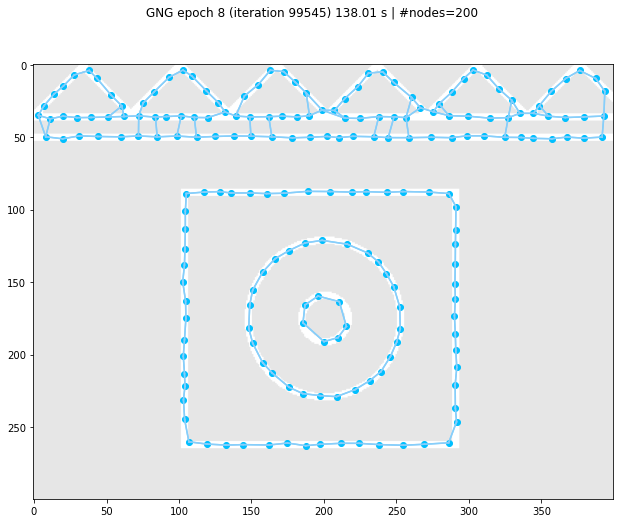

1146.9385607000004


In [86]:
start_time = perf_counter()
# gng.learn(binary_img, normalized_data)
gng.learn(binary_img, data, visualize=True, display_iteration=1000, max_epoch=8)
print(perf_counter() - start_time)

In [87]:
histories[gng.get_experiment_name()] = gng.history.copy()

0.8468802944318695


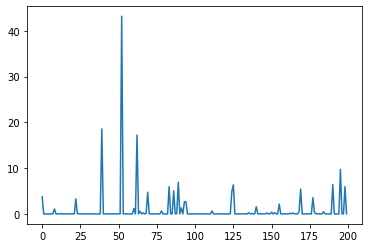

In [88]:
errors = [gng.nodes[i]["error"] for i in gng.nodes]
print(np.mean(errors))
fig, ax = plt.subplots()
ax.plot(errors)

In [89]:
CONDITION_PLOT = "node_200" #"step_0.25-sn_0.005"

step_0.25-sn_0.005-age_20-t_add_20-it_93000-a_0.5-d_0.75-node_200-max_200
(0,nan)
(1,297.8387329997786)
(2,26.808201295098165)
(3,26.684805185077526)
(4,25.948577676196688)
(5,26.21993633183839)
(6,26.500331196746792)
(7,26.129970050761564)
step_0.25-sn_0.005-age_20-t_add_20-it_99545-a_0.5-d_0.9-node_200-max_200
(0,nan)
(1,486.5906460349816)
(2,34.15907652990036)
(3,33.38657891516828)
(4,33.54867313594747)
(5,33.11121559680623)
(6,33.54411115202946)
(7,33.25912187967531)
(8,33.373494794107096)
step_0.25-sn_0.005-age_20-t_add_20-it_99545-a_0.5-d_0.85-node_200-max_200
(0,nan)
(1,340.7028508299257)
(2,31.690992475549596)
(3,31.291591234631706)
(4,30.748197851837613)
(5,30.497129629985505)
(6,30.14678445064075)
(7,30.316430493972558)
(8,30.18154574229819)
step_0.25-sn_0.005-age_20-t_add_20-it_124431-a_0.5-d_0.5-node_200-max_200
(0,nan)
(1,186.59352547907886)
(2,21.741700849300305)
(3,21.007385577031375)
(4,21.105603869602547)
(5,21.063298237142167)
(6,20.61255950809362)
(7,20.7286912181408

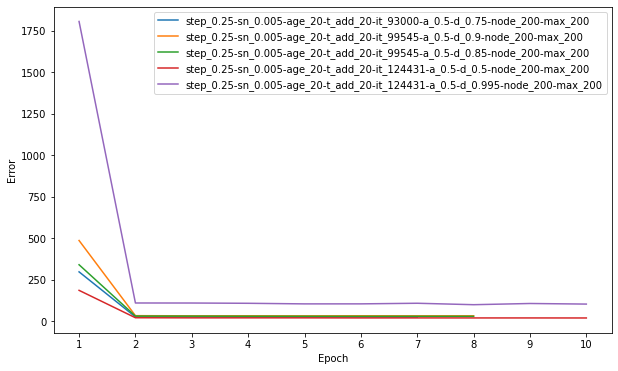

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
for history in natsorted(histories):
    if CONDITION_PLOT not in history:
        continue
    losses = [h["epoch_error"] for h in histories[history]]
    ax.plot(losses, label=history)
    
    print(history)
    for i, l in enumerate(losses):
        print(f"({i},{l})")
ax.set_xticks(np.arange(1, len(losses)))
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.legend()

In [91]:
np.argmin(losses[1:])

7

In [92]:
losses

[nan,
 1804.8472403510007,
 110.511087545118,
 110.30842597267852,
 108.66989527474925,
 105.13332984061984,
 105.25694692609848,
 108.90412777490101,
 100.22117619517645,
 107.49318383645245,
 103.94377187954565]

step_0.25-sn_0.005-age_20-t_add_20-it_124431-a_0.5-d_0.995-node_200-max_200
(2,110.511087545118)
(3,110.30842597267852)
(4,108.66989527474925)
(5,105.13332984061984)
(6,105.25694692609848)
(7,108.90412777490101)
(8,100.22117619517645)
(9,107.49318383645245)
(10,103.94377187954565)
step_0.25-sn_0.005-age_20-t_add_20-it_124431-a_0.5-d_0.5-node_200-max_200
(2,21.741700849300305)
(3,21.007385577031375)
(4,21.105603869602547)
(5,21.063298237142167)
(6,20.61255950809362)
(7,20.728691218140863)
(8,20.534934762193373)
(9,20.53204482529139)
(10,20.320686870558568)


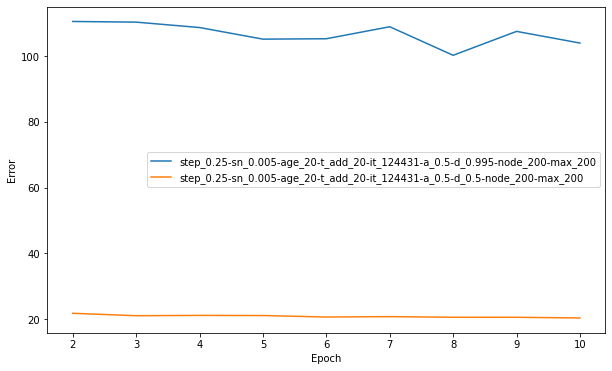

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
for history in histories:
    if CONDITION_PLOT not in history:
        continue
    losses = [h["epoch_error"] for h in histories[history]]
#     print(losses)
    losses.pop(0)
    losses.pop(0)
    print(history)
    X = np.arange(1, len(losses)+1) + 1
    for l, x in zip(losses, X):
        print(f"({x},{l})")
    ax.plot(X, losses, label=history)
ax.set_xticks(X)
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.legend()

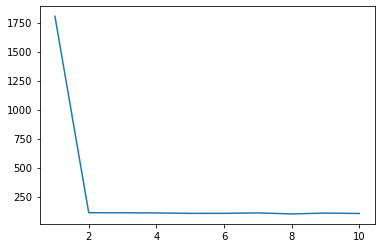

In [50]:
losses = [h["epoch_error"] for h in gng.history]
fig, ax = plt.subplots()
ax.plot(losses)

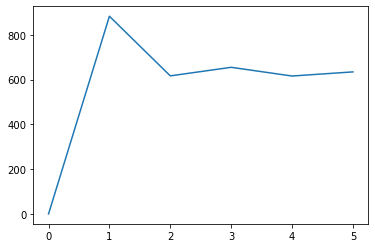

In [29]:
losses = [h["total_loss"] for h in gng.history]
fig, ax = plt.subplots()
ax.plot(losses)

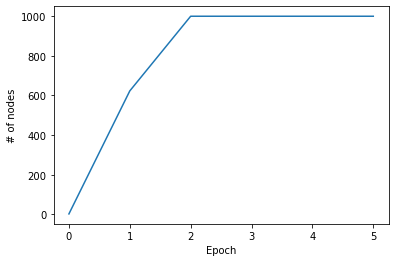

In [30]:
num_nodes = [h["num_nodes"] for h in gng.history]
fig, ax = plt.subplots()
ax.plot(num_nodes)
ax.set_xlabel("Epoch")
ax.set_ylabel("# of nodes")
plt.show()
fig.savefig(f'{img_name}-{gng.get_experiment_name()}-time.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

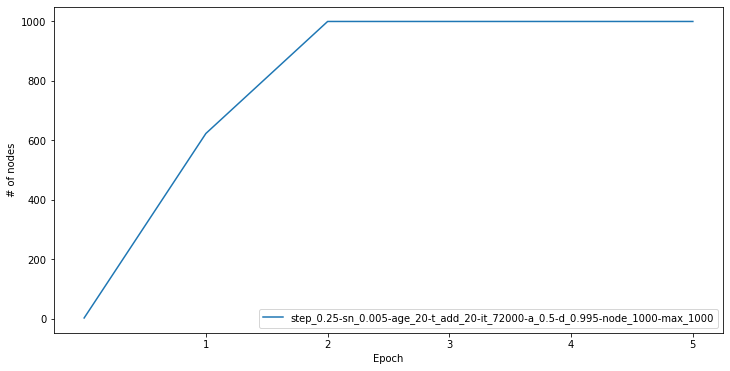

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
for history in histories:
    Y = [h["num_nodes"] for h in histories[history]]
    ax.plot(Y, label=history)
ax.set_xticks(np.arange(1, len(Y)))
ax.set_xlabel("Epoch")
ax.set_ylabel("# of nodes")
plt.legend()

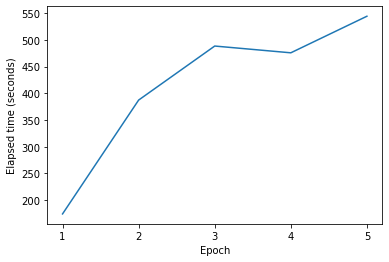

In [32]:
times = [h["time"] for h in gng.history]
fig, ax = plt.subplots()
ax.plot(times)
ax.set_xticks(np.arange(1, len(times)))
ax.set_xlabel("Epoch")
ax.set_ylabel("Elapsed time (seconds)")
plt.show()
fig.savefig(f'{img_name}-{gng.get_experiment_name()}-time.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

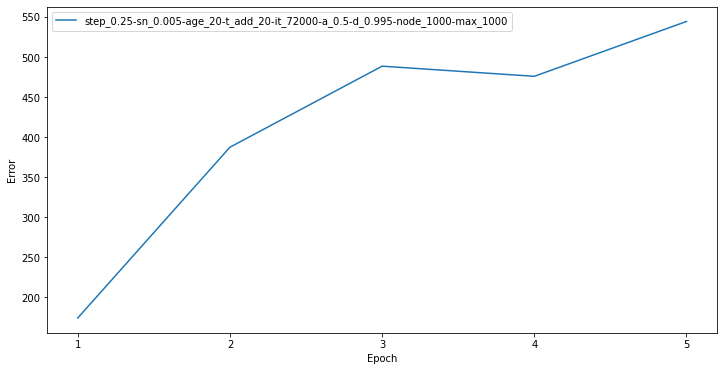

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
for history in histories:
    Y = [h["time"] for h in histories[history]]
    ax.plot(Y, label=history)
ax.set_xticks(np.arange(1, len(Y)))
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.legend()

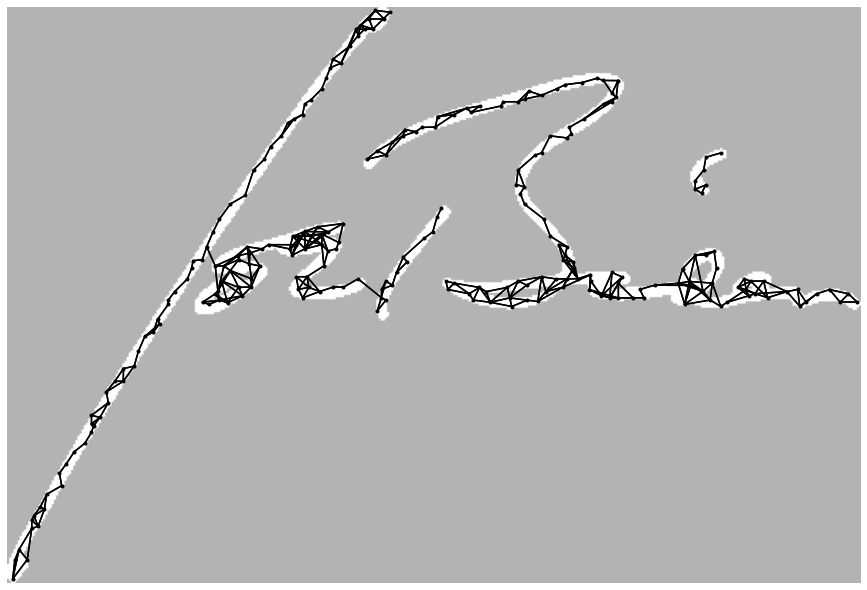

In [88]:
fig = gng.draw_image(figsize=(12, 8), show_node=True, show_image=True)
# plt.text(10, 280, gng.get_experiment_name(), ha='left', wrap=True, size=13)
fig.savefig(f'{img_name}-{gng.get_experiment_name()}-network.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
np.max(normalized_data)

In [ ]:
df = []
# binary_img = ~binary_img
for (x, y), val in np.ndenumerate(binary_img):
    if val == False:
        df.append([y, -x])
scale_factor = 0.001   
data = scale_factor * np.array(df)
print("Number of data points: {:,}".format(len(data)))

plt.figure(figsize=(20, 27.5))
plt.scatter(*np.array(data).T / scale_factor, s=3, alpha=1)

# neupy

In [86]:
def create_gng(max_nodes, step=0.2, n_start_nodes=2, max_edge_age=50):
    return algorithms.GrowingNeuralGas(
        n_inputs=2,
        n_start_nodes=n_start_nodes,

        shuffle_data=True,
        verbose=True,

        step=step,
        neighbour_step=0.005,

        max_edge_age=max_edge_age,
        max_nodes=max_nodes,

        n_iter_before_neuron_added=100,
        after_split_error_decay_rate=0.5,
        error_decay_rate=0.995,
        min_distance_for_update=0.01,
    )

In [87]:
def draw_image(graph, show=True):
    for node_1, node_2 in graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=0.2, color='black')

    plt.xticks([], [])
    plt.yticks([], [])
    
    if show:
        plt.show()

In [89]:
scale_factor = 1

In [90]:
a = (data / scale_factor)
len(a)

4110

In [91]:
for x, y in a:
    print(x, y)
    break

18.0 284.0


In [92]:
data_img = np.zeros((300, 200))
for x, y in a.astype("int"):
    data_img[-y, x] = 1
data_img = np.logical_not(data_img).astype(int)

IndexError: index -301 is out of bounds for axis 0 with size 300

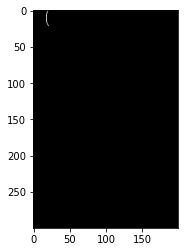

In [95]:
plt.figure()
plt.imshow(data_img, cmap="gray")

In [96]:
np.unique(data_img, return_counts=True)

(array([0., 1.]), array([59978,    22], dtype=int64))

In [97]:
np.unique(data_img, return_counts=True)

(array([0., 1.]), array([59978,    22], dtype=int64))

In [98]:
np.unique(binary_img, return_counts=True)

(array([0., 1.], dtype=float32), array([115890,   4110], dtype=int64))

In [99]:
data[:, 0].min(), data[:, 0].max(), data[:, 1].min(), data[:, 1].max()

(18, 220, 67, 357)

In [120]:
df = []
invert_binary_img = binary_img
for (x, y), val in np.ndenumerate(invert_binary_img):
    if val == False:
        df.append([y, -x])
scale_factor = 1#0.001   
neupy_data = scale_factor * np.array(df)
print("Number of data points: {:,}".format(len(data)))

Number of data points: 4,110


In [124]:
neupy_data = data


Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] train_end_signal = None
[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 2400
[OPTION] min_distance_for_update = 0.01
[OPTION] n_inputs = 2
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.005
[OPTION] step = 0.2


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      15.677 |           - |      198 ms |
---------------------------------------------------------



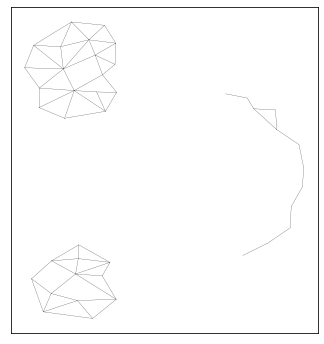


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           2 |      6.8257 |           - |      317 ms |
---------------------------------------------------------



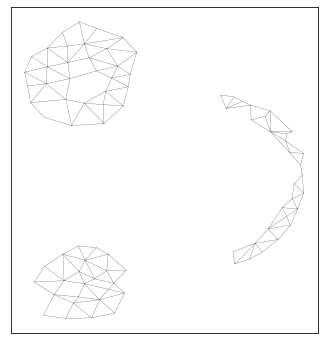


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           3 |      5.1474 |           - |      429 ms |
---------------------------------------------------------



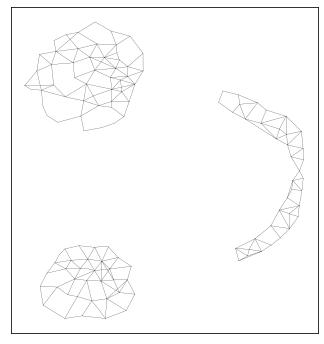


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           4 |      4.1958 |           - |      541 ms |
---------------------------------------------------------



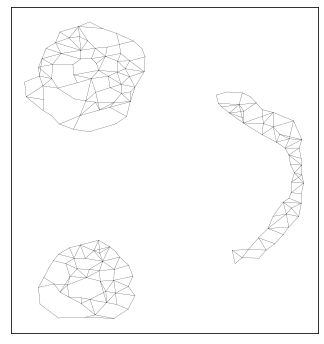


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           5 |       3.632 |           - |      629 ms |
---------------------------------------------------------



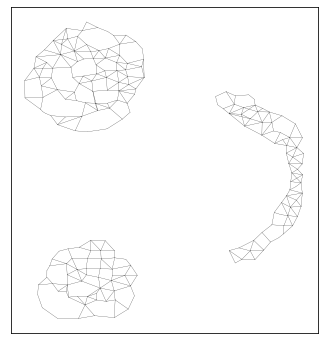


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           6 |      3.2271 |           - |      740 ms |
---------------------------------------------------------



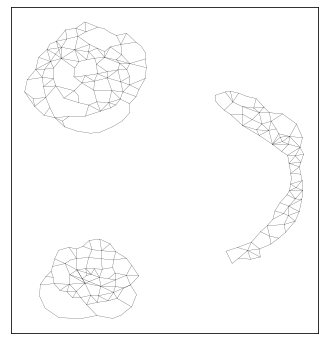


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           7 |      2.9149 |           - |      859 ms |
---------------------------------------------------------



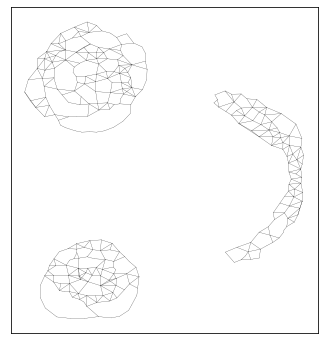


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           8 |      2.6455 |           - |      946 ms |
---------------------------------------------------------



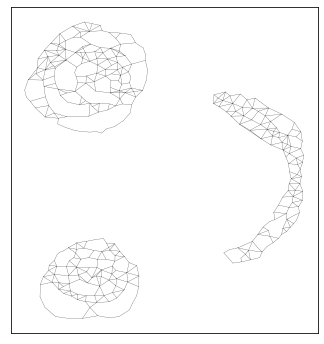


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           9 |       2.426 |           - |       1 sec |
---------------------------------------------------------



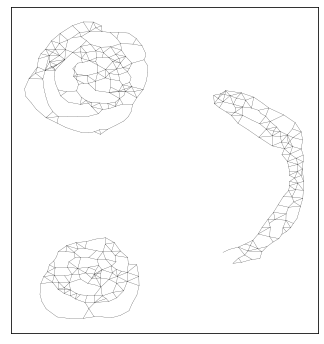


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          10 |      2.2444 |           - |       1 sec |
---------------------------------------------------------



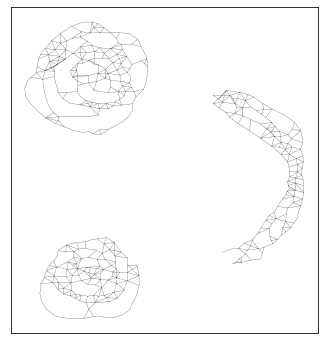


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          11 |      2.1074 |           - |       1 sec |
---------------------------------------------------------



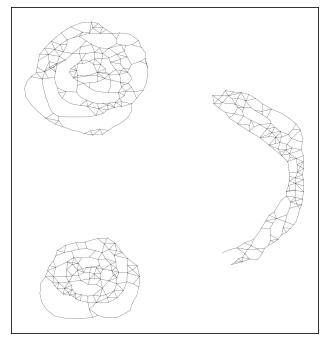


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          12 |      1.9842 |           - |       1 sec |
---------------------------------------------------------



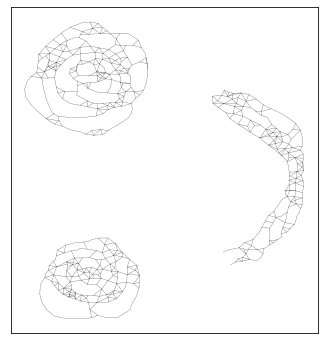


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          13 |      1.8808 |           - |       1 sec |
---------------------------------------------------------



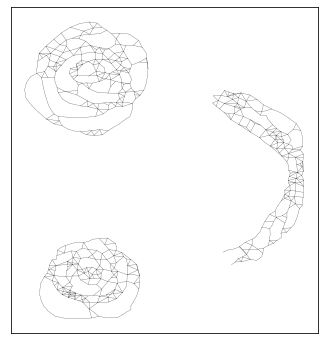


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          14 |      1.7703 |           - |       1 sec |
---------------------------------------------------------



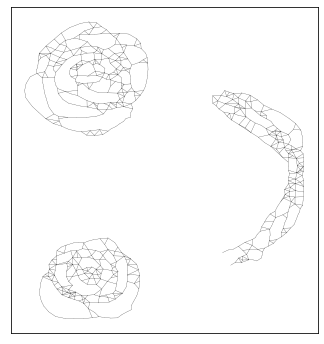


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          15 |      1.6833 |           - |       1 sec |
---------------------------------------------------------



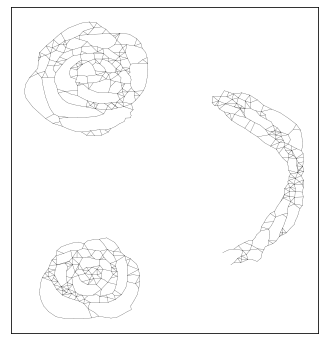


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          16 |      1.6031 |           - |       1 sec |
---------------------------------------------------------



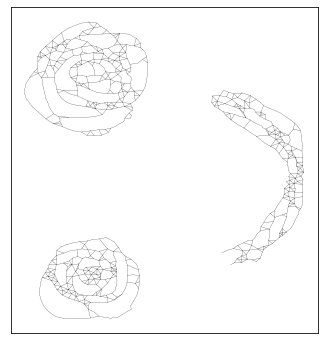


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          17 |      1.5214 |           - |       1 sec |
---------------------------------------------------------



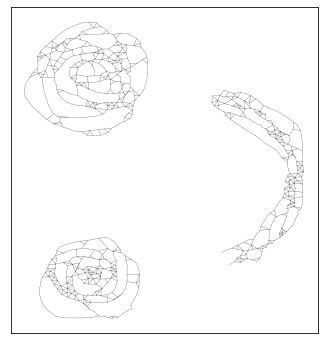


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          18 |      1.4549 |           - |       1 sec |
---------------------------------------------------------



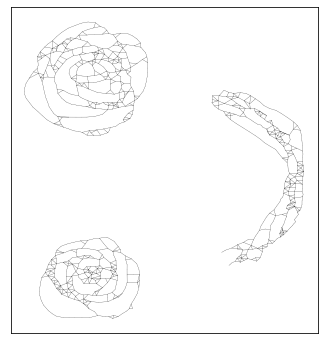


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          19 |      1.3942 |           - |       2 sec |
---------------------------------------------------------



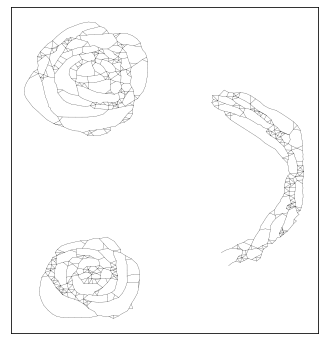


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          20 |      1.3395 |           - |       2 sec |
---------------------------------------------------------



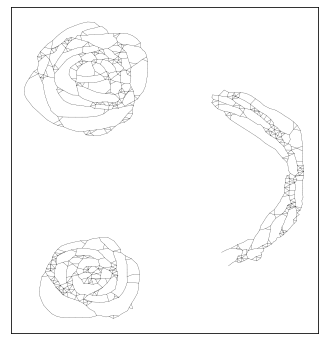

In [125]:
from neupy import algorithms, utils
    
# utils.reproducible()
neupy_gng = create_gng(max_nodes=2400)

for epoch in range(20):
    neupy_gng.train(neupy_data, epochs=1)
    
    # Plot images after each iteration in order to see training progress
    plt.figure(figsize=(5.5, 6))
    draw_image(neupy_gng.graph)

NameError: name 'numpy' is not defined

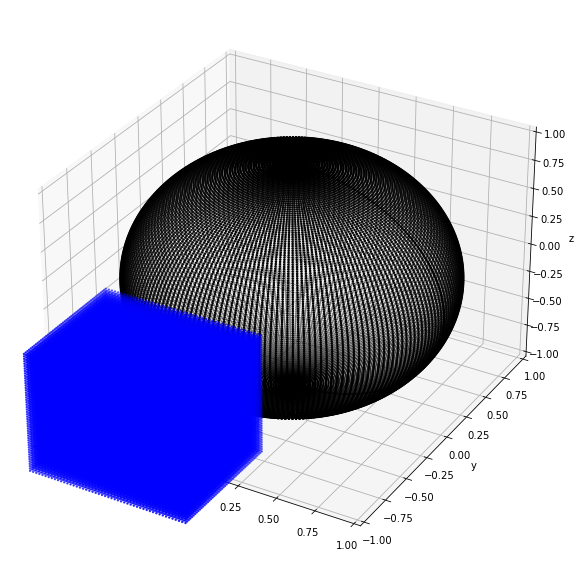

In [469]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:200j, 0.0:2.0*pi:200j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

# Create a cube
X, Y, Z = np.mgrid[-0.5:0.5:50j, -1.2:-2.0:50j, -0.5:0.5:50j]

#Set colours and render
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(
#     x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

ax.scatter(x,y,z,color="k",s=2)
ax.scatter(X,Y,Z,color="b",s=2)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# ax.set_aspect(1)
plt.tight_layout()
plt.show()

In [460]:
x.shape, y.shape, z.shape

((100, 100), (100, 100), (100, 100))

In [459]:
X.shape, Y.shape, Z.shape

((100, 100, 100), (100, 100, 100), (100, 100, 100))

In [462]:
np.mgrid[-0.5:0.5:100j, -1.2:-2.0:100j, -0.5:0.5:100j].shape

(3, 100, 100, 100)